In [1]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First we need some data -- either run the benchmarking function, or load the data from an existing file.

In [2]:
def run(
	grid_n_vals: list[int] = [2,3,4,5,6,7] + np.logspace(3, 6, 7, base=2, dtype=int).tolist(),
	n_mazes_vals: list[int] = np.logspace(0, 3, 4, base=2, dtype=int)
):
	print(f"{grid_n_vals=}\n{n_mazes_vals=}")

	# run the benchmark
	from benchmark_generation import run_benchmark

	df: pd.DataFrame = run_benchmark(
		save_path = "benchmark_temp.jsonl",
		base_configs = None, # this defaults to DEFAULT_GENERATORS
		grid_n_vals = grid_n_vals,
		n_mazes_vals = n_mazes_vals,
		trials = 10,
		verbose = False,
	)

# uncomment this to run
# run()

In [3]:
# or just load the results
df: pd.DataFrame = pd.read_json("benchmark_large.jsonl", orient="records", lines=True)

Let's process the data a bit, adding some useful fields

In [4]:
# Convert the `maze_ctor_kwargs` column to string type for easier grouping
df['maze_ctor_kwargs_json'] = df['maze_ctor_kwargs'].apply(lambda x: json.dumps(x, sort_keys=True))

# Convert the 'time' to milliseconds for easier interpretation in the plot
df['time_ms'] = df['time'] * 1000
# time per maze
df['time_normalized'] = df['time_ms'] / df['n_mazes']

# group sizes
_size_map = lambda x: (
	"small\n($g \\leq 10)$" if x <= 10 else
	"medium\n($10 < g \\leq 32$)" if x <= 32 else
	"large\n($g > 32$)"
)
df["size_grouped"] = df["grid_n"].apply(_size_map)

print(df)


      cfg_name  grid_n  n_mazes        maze_ctor  \
0    benchmark       6        1          gen_dfs   
1    benchmark       3        2         gen_prim   
2    benchmark      22        2         gen_prim   
3    benchmark       5        4          gen_dfs   
4    benchmark      32        4          gen_dfs   
..         ...     ...      ...              ...   
671  benchmark      32        4       gen_wilson   
672  benchmark       7        2  gen_percolation   
673  benchmark       8        2          gen_dfs   
674  benchmark       4        4          gen_dfs   
675  benchmark      11        4         gen_prim   

                                     maze_ctor_kwargs  trials      time  \
0                             {'max_tree_depth': 0.5}      10  0.005828   
1                           {'accessible_cells': 0.5}      10  0.002891   
2                             {'max_tree_depth': 0.5}      10  0.028758   
3                            {'accessible_cells': 20}      10  0.012907   


Plotting and tables:

In [5]:
# You can use the Pandas `pivot_table` function to generate the aggregated table in a cleaner way.
# First, create a pivot table for the average time
pivot_avg_time = pd.pivot_table(
    df, 
    values='time_normalized', 
    index=['maze_ctor', 'maze_ctor_kwargs_json'], 
    columns=['size_grouped'], 
    aggfunc='mean',
).reset_index()

# Rename the columns for clarity
print(pivot_avg_time.columns)
pivot_avg_time.columns = ['maze_ctor', 'maze_ctor_kwargs_json', 'avg_time_large', 'avg_time_medium', 'avg_time_small']

# Calculate the overall average time for each group
overall_avg_time = df.groupby(['maze_ctor', 'maze_ctor_kwargs_json'])['time_normalized'].mean().reset_index()
overall_avg_time.columns = ['maze_ctor', 'maze_ctor_kwargs_json', 'avg_time']

# Merge the overall average time with the pivot table
final_df = pd.merge(overall_avg_time, pivot_avg_time, on=['maze_ctor', 'maze_ctor_kwargs_json'], how='left')

# Format the keyword arguments
final_df['keyword_args'] = final_df['maze_ctor_kwargs_json'].apply(lambda x: ", ".join(f"{k}={v}" for k, v in json.loads(x).items()))

# Reorder the columns
final_df = final_df[['maze_ctor', 'keyword_args', 'avg_time', 'avg_time_small', 'avg_time_medium', 'avg_time_large']]

final_df.head()

latex_table = final_df.to_latex(index=False, float_format="%.3f")
print(latex_table)

Index(['maze_ctor', 'maze_ctor_kwargs_json', 'large\n($g > 32$)',
       'medium\n($10 < g \leq 32$)', 'small\n($g \leq 10)$'],
      dtype='object', name='size_grouped')
\begin{tabular}{llrrrr}
\toprule
          maze\_ctor &                             keyword\_args &  avg\_time &  avg\_time\_small &  avg\_time\_medium &  avg\_time\_large \\
\midrule
            gen\_dfs &                      accessible\_cells=20 &     2.445 &           2.402 &            2.553 &           2.379 \\
            gen\_dfs &                           do\_forks=False &     3.006 &           2.407 &            3.657 &           3.799 \\
            gen\_dfs &                       max\_tree\_depth=0.5 &     4.456 &           2.161 &            4.900 &          11.602 \\
            gen\_dfs &                                          &    31.134 &           2.845 &           27.967 &         136.483 \\
gen\_dfs\_percolation &                                    p=0.1 &    53.936 &           3.613 &         

C:\Users\mivan\AppData\Local\Temp\ipykernel_10472\3139553046.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = final_df.to_latex(index=False, float_format="%.3f")


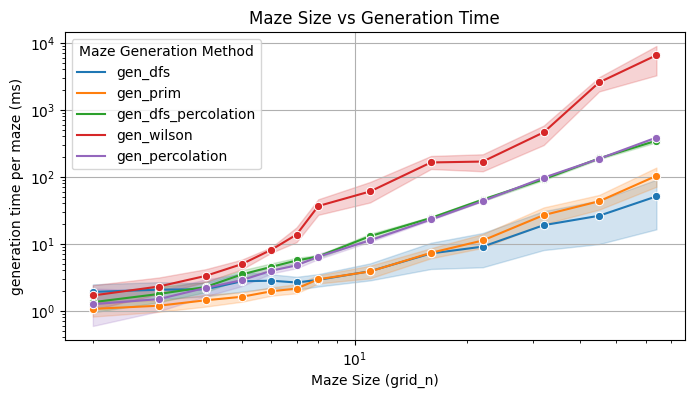

In [6]:
# Plot maze size vs generation time for each method
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x='grid_n', y='time_normalized', hue='maze_ctor', marker='o')
plt.title('Maze Size vs Generation Time')
plt.xlabel('Maze Size (grid_n)')
plt.ylabel('generation time per maze (ms)')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Maze Generation Method')
plt.grid(True)
plt.savefig('gridsize-vs-gentime.pdf')
plt.show()

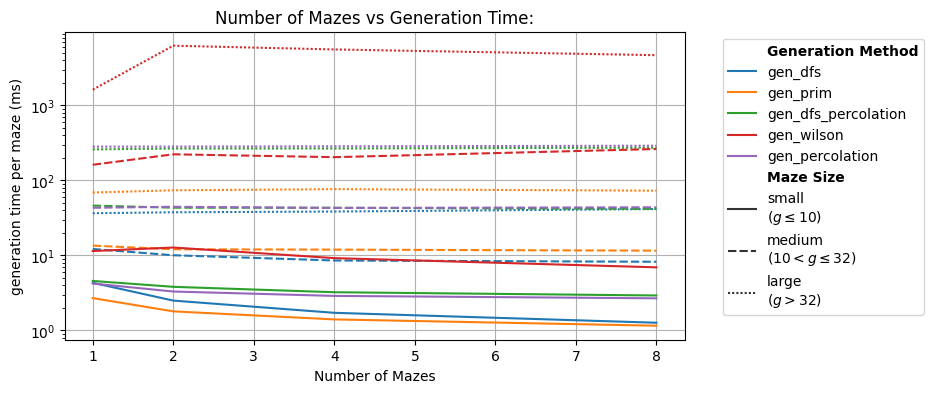

In [7]:
# number of mazes vs generation time (per maze)
plt.figure(figsize=(8, 4))
sns.lineplot(
	data=df,
	x='n_mazes', 
	y='time_normalized', 
	hue='maze_ctor',
	style='size_grouped',
	# marker='o', 
	errorbar=None,
	# make legend contain all labels
	legend='full',
)
plt.title(f'Number of Mazes vs Generation Time:')
plt.xlabel('Number of Mazes')
plt.ylabel('generation time per maze (ms)')
# plt.xscale('log')
plt.yscale('log')

# Create the legend and place it outside the plot
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Make the titles of the areas in the legend bold
for t in legend.texts:
	if t.get_text() == 'maze_ctor':
		t.set_text('Generation Method')
		t.set_weight('bold')
	elif t.get_text() == 'size_grouped':
		t.set_text('Maze Size')
		t.set_weight('bold')

plt.grid(True)
plt.savefig('n_mazes-vs-gentime.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

<Axes: title={'center': 'Benchmark'}, xlabel='Number of mazes', ylabel='Time (s)'>

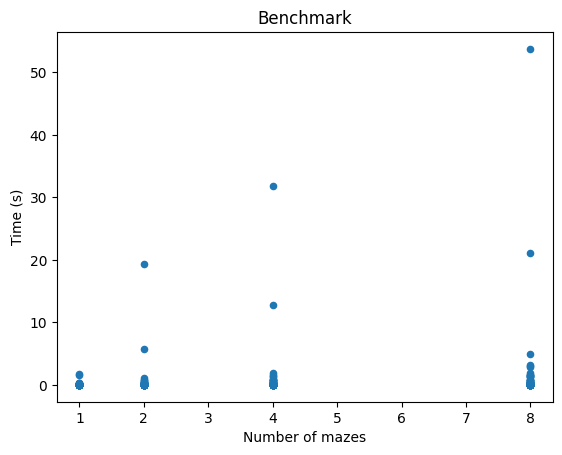

In [8]:
# junk
df.plot(
	x = "n_mazes",
	y = "time",
	kind = "scatter",
	# logx = True,
	# logy = True,
	title = "Benchmark",
	xlabel = "Number of mazes",
	ylabel = "Time (s)",
)